In [1]:
import requests
import json
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
from label_mappings import CATEGORY_LABEL_MAPPING_CHINESE, SENTIMENT_LABEL_MAPPING_CHINESE, CATEGORY_LABEL_MAPPING, SENTIMENT_LABEL_MAPPING
from transformers import AutoTokenizer, TFAutoModel
from label_mappings import *
from utils.eval_utils import quick_test
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.sans-serif'] = ['FangSong']

%matplotlib inline
url = "http://127.0.0.1:3030/absa_service"

In [15]:
import json
import tensorflow as tf
import os
from my_datasets import TestTokenizer
from models.end_to_end_model import End2EndAspectSentimentModel
model_checkpoint = "checkpoint/ttee_pretrain_db_amazon_less_pos.csv_pretrain_60000steps_0d_2e-5lr_3000_0.96_schedule_0cased_update_0.2dropout/"
ckpt_path = tf.train.latest_checkpoint(model_checkpoint)
config_path = os.path.join(model_checkpoint, "model_config.json")
config = json.load(open(config_path))

model = End2EndAspectSentimentModel.from_config(config)
ckpt = tf.train.Checkpoint(model=model)
ckpt.restore(ckpt_path)

init_dir = "bert_models/bert-base-uncased"
init_model = 'bert-base-uncased'
mask_sb = True
model_type = "end_to_end"
tokenizer = AutoTokenizer.from_pretrained(init_model, cache_dir=init_dir)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
test_tokenizer = TestTokenizer(tokenizer, ASPECT_SENTENCE, mask_sb, model_type)
signatures = {
    "text_inputs": [tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None, None), dtype=tf.int32)],
    "aspect_inputs": [tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32)]
}
test_func = model.call.get_concrete_function(text_inputs=signatures['text_inputs'], aspect_inputs=signatures['aspect_inputs'], label_inputs=None, phase="dynamic_aspect_test", output_attentions=True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config o

In [30]:
output["sim_matrix"].numpy().squeeze().shape

(2, 7)

In [25]:
test_data = [
    "the actor is skillful"
]

aspect_texts = [
    ["actor negative","actor positive"]
]
data = test_tokenizer.tokenize(test_data, aspect_texts=aspect_texts)
inputs = [data['input_ids'], data['token_type_ids'], data['attention_mask']]
aspect_inputs = [data['aspect_input_ids'], data['aspect_token_type_ids'], data['aspect_attention_mask']]
output = test_func(inputs, aspect_inputs, phase="dynamic_aspect_test", output_attentions=True)
output

{'decoded_sequence': <tf.Tensor: shape=(1, 2, 7), dtype=int32, numpy=
 array([[[2, 2, 2, 2, 2, 2, 2],
         [2, 0, 0, 1, 1, 1, 2]]], dtype=int32)>,
 'output_logits': <tf.Tensor: shape=(1, 2, 7, 3), dtype=float32, numpy=
 array([[[[-0.1669796 , -1.6778868 ,  0.61547637],
          [-0.09087022, -1.7726648 ,  1.1595626 ],
          [-0.06830747, -1.9053862 ,  1.136948  ],
          [ 0.0103267 , -1.3999176 ,  1.560569  ],
          [-0.04481225, -1.8301318 ,  1.4415036 ],
          [-0.09360442, -1.0631171 ,  1.3002411 ],
          [-0.15142193, -1.5873775 ,  0.3991184 ]],
 
         [[ 0.77764285, -0.9992767 ,  1.2055669 ],
          [ 0.117208  , -0.20450467, -0.35648823],
          [ 0.20783824, -0.28020895, -0.30298993],
          [-0.01062569, -0.24839932, -0.7449305 ],
          [ 0.07454619, -0.24513245, -0.60293424],
          [ 0.0677554 , -0.5757812 , -0.51151335],
          [ 0.9678682 , -1.4564434 ,  2.4375672 ]]]], dtype=float32)>,
 'output_cls_states': <tf.Tensor: shape=

In [10]:
test_data = {"text": ["The apple juice is good, i like it"],
        "language": "en",
        "output_attentions": False,
}
res = requests.post(url, json=test_data)
res.json()

{'origin_text': ['The apple juice is good, i like it'],
 'result': [[{'target': 'apple juice',
    'aspect': 'FOOD#QUALITY',
    'polarity': 'positive',
    'prob': 0.986777126789093}]],
 'time_cost': 0.30402159690856934,
 'status': 'success',
 'error_code': 0}

In [3]:
cn_init_dir = '../models/bert-base-chinese'
cn_init_model = 'bert-base-chinese'

en_init_dir = '../models/bert-base-cased'
en_init_model = 'bert-base-cased'
cn_tokenizer = AutoTokenizer.from_pretrained(cn_init_model, cache_dir=cn_init_dir)
en_tokenizer = AutoTokenizer.from_pretrained(en_init_model, cache_dir=en_init_dir)

In [106]:
tf.reduce_mean(tf.constant([[1,2,3], [5, 6, 7]]), axis=0)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 4, 5], dtype=int32)>

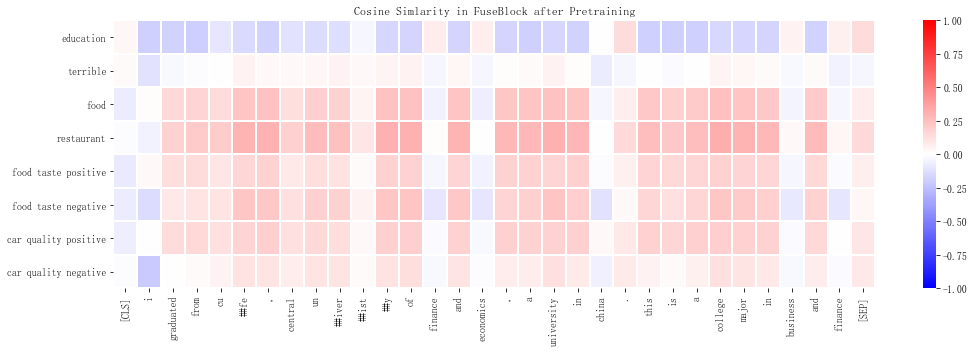

[[ 9.466264  -3.92084   -6.489458  -5.8416853 -6.363233  -6.7940354
  -6.1813293 -5.442578 ]]


In [101]:
def draw_sim_matrix_dynamic(context, aspect, infer_func, tokenizer):
    data = tokenizer.tokenize(context, aspect_texts=aspect)
    inputs = [data['input_ids'], data['token_type_ids'], data['attention_mask']]
    aspect_inputs = [data['aspect_input_ids'], data['aspect_token_type_ids'], data['aspect_attention_mask']]
    output = infer_func(inputs, aspect_inputs, phase="dynamic_aspect_test", output_attentions=True)
    sim_matrix = np.array(output['sim_matrix']).squeeze()
    key_inputs = tokenizer.tokenizer.tokenize(context[0], add_special_tokens=True)
    query_inputs = aspect[0]
    df = pd.DataFrame(sim_matrix[:, :len(key_inputs)])
    df.index = query_inputs
    df.columns = key_inputs
    plt.figure(figsize=(15, 5))
    sns.heatmap(df, linewidths = 0.1, vmax=1, vmin=-1, cmap="bwr")
    plt.title("Cosine Simlarity in FuseBlock after Pretraining")
    plt.tight_layout()
    # plt.savefig('./plots/fusebock_sim_matrix_cn_all_3t.jpg', dpi=300)
    # plt.show()
    return output["output_cls_states"].numpy()
    
context = [
    "I graduated from CUFE, central univeristy of finance and economics, a university in china. This is a college major in business and finance"
    # "I didn't eat any food in this restaurant"
]

aspect_texts = [
    ["education", "terrible", "food", "restaurant", "food taste positive", "food taste negative", "car quality positive", "car quality negative"]
]
res = draw_sim_matrix_dynamic(context, aspect_texts, test_func, test_tokenizer)
# plt.savefig('./plots/pretrain_sim_matrix.jpg', dpi=300)
plt.show()
print(res)


In [92]:
(1 / (1 + np.exp))

array([[0.00257106, 0.9904721 , 0.05473941, 0.05446907, 0.00282561,
        0.9351004 , 0.00166256, 0.00404515]], dtype=float32)

In [4]:
def draw_sim_matrix(text, language):
    
    test_data = {
        "text": text,
        "output_attentions": True,
        "language": language
    }
    
    if language == "cn":
        key_inputs = cn_tokenizer.tokenize(test_data["text"][0], add_special_tokens=True)
    else:
        key_inputs = en_tokenizer.tokenize(test_data["text"][0], add_special_tokens=True)       
        
    res = requests.post(url, json=test_data).json()    
    query_inputs = []
    
    c2l = CATEGORY_LABEL_MAPPING_CHINESE if language == "cn" else CATEGORY_LABEL_MAPPING
    s2l = SENTIMENT_LABEL_MAPPING_CHINESE if language == "cn" else SENTIMENT_LABEL_MAPPING
    for asp in c2l:
        for senti in s2l:
            query_inputs.append(asp + "_" + senti)

    sim_matrix = np.array(res['attentions']).squeeze()

    df = pd.DataFrame(sim_matrix[:, :len(key_inputs)])
    df.index = query_inputs
    df.columns = key_inputs
    plt.figure(figsize=(20, 10))
    sns.heatmap(df, linewidths = 0.1, vmax=1, vmin=-1, cmap="bwr")
    plt.title("Cosine Simlarity in FuseBlock")
    plt.tight_layout()
    # plt.savefig('./plots/fusebock_sim_matrix_cn_all_3t.jpg', dpi=300)
    plt.show()

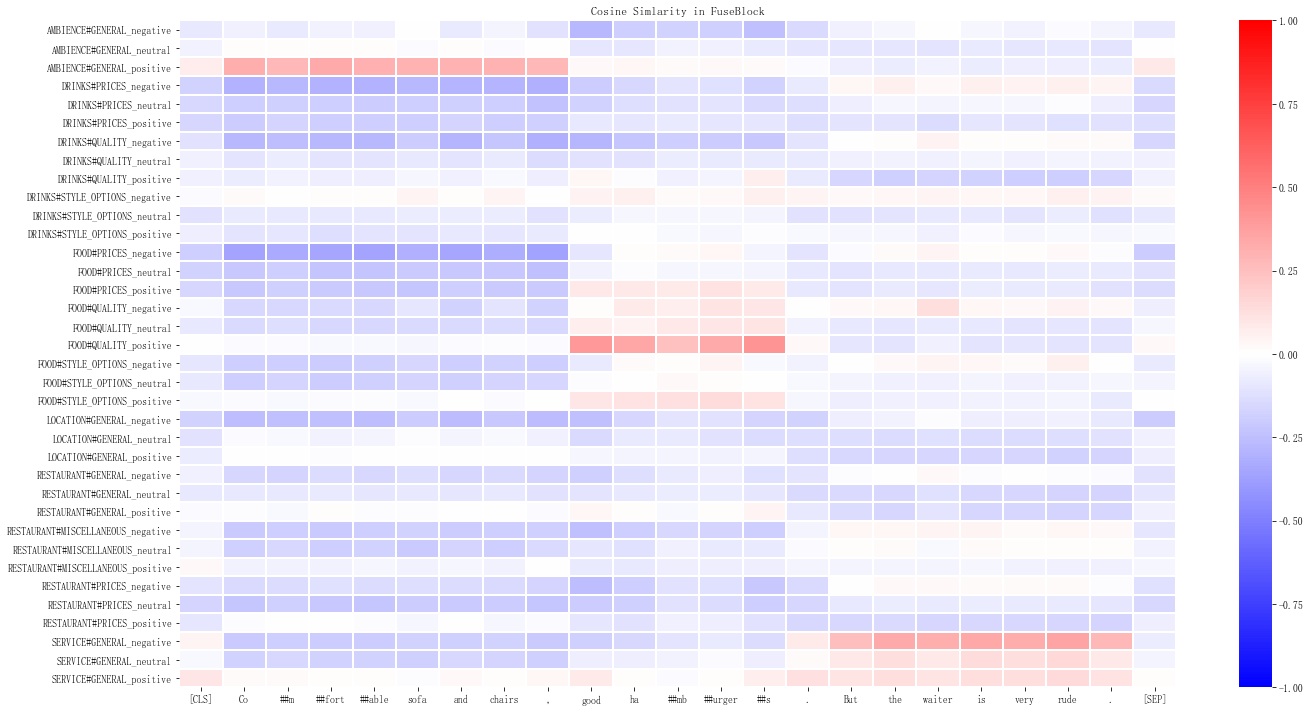

In [11]:
text =  [
#     "屏幕质量不错，很抗摔；电池续航很好，可以待机两天；相机不是很给力，拍出来有点模糊",
    "Comfortable sofa and chairs, good hamburgers. But the waiter is very rude."
]
language = "en"
draw_sim_matrix(text, language)